# **Recommendation System (based on Ranking)**

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Import**

Import modules and library needed

In [4]:
!pip install -q tensorflow-recommenders

In [5]:
import pandas as pd
import numpy as np

import tensorflow as tf

import tensorflow_recommenders as tfrs
import matplotlib.pyplot as plt
from typing import Dict, Text

### **Prepare Dataset**

In [6]:
df = pd.read_csv("/content/drive/MyDrive/Capstone Project/Machine Learning/datasets/ratings.csv")
df.head()

,user_id,mountain_id,rating
0,1,149,3
1,1,219,3
2,1,76,4
3,9,84,1
4,9,63,5


In [7]:
print('Length of dataset rating :', len(df))

Length of dataset rating : 3232


In [31]:
# Check duplicate data
print("Data duplicated: ", df.duplicated().sum())

if df.duplicated().sum() > 0:
    df_clean = df[~df.duplicated()]

print('Length of dataset rating after cleaning:', len(df_clean))

Data duplicated:  6
Length of dataset rating after cleaning: 3226


In [32]:
#Unique User IDs and Mountain IDs 
unique_user_ids = len(df_clean.user_id.unique())
unique_mountain_ids = len(df_clean.mountain_id.unique())

print(unique_mountain_ids, 'Mountain IDs')
print(unique_user_ids, 'User IDs')

232 Mountain IDs
500 User IDs


## **Exploration**

In [10]:
#Popular Mountain
df_clean.groupby('mountain_id')['rating'].mean().sort_values(ascending=False)[:10]

mountain_id
47     4.000000
16     4.000000
181    3.818182
66     3.750000
65     3.733333
88     3.727273
70     3.705882
172    3.642857
182    3.636364
197    3.625000
Name: rating, dtype: float64

In [41]:
#How often each user goes hiking
df_freq = df_clean.groupby('user_id').count().groupby('rating').count()
df_freq.columns = ['count']
df_freq.index.names = ['Hiking Frequency']
print(df_freq)

                  count
Hiking Frequency       
3                    60
4                    61
5                    65
6                    69
7                    66
8                    65
9                    59
10                   55


In [42]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df_clean, test_size=0.2, shuffle=True, random_state=88)

print('There are :', len(train), 'object on train examples')
print('There are :', len(val), 'object on val examples')

There are : 2580 object on train examples
There are : 646 object on val examples


## **Implementing Model**

In [44]:
embedding_dimension = 32

user_id = tf.keras.layers.Input(shape=[1], name="user_id")
user_embedding = tf.keras.layers.Embedding(unique_user_ids + 1, embedding_dimension)(user_id)

mountain_id = tf.keras.layers.Input(shape=[1], name="mountain_id")
mountain_embedding = tf.keras.layers.Embedding(unique_mountain_ids + 1, embedding_dimension)(mountain_id)

x = tf.keras.layers.Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, mountain_embedding])
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x)

In [45]:
# Create model and compile it
model = tf.keras.Model([user_id, mountain_id], x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 mountain_id (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 32)        16032       ['user_id[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 32)        7456        ['mountain_id[0][0]']            
                                                                                              

In [46]:
#Compile
model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=["mae", "mse"], optimizer='Adagrad')

In [47]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
# Train the model
history = model.fit([train.user_id, train.mountain_id], train.rating, epochs=150, callbacks=[lr_schedule])

Epoch 1/150
81/81 [==============================] - 1s 2ms/step - loss: 10.9763 - mae: 2.9954 - mse: 10.9763 - lr: 1.0000e-08
Epoch 2/150
81/81 [==============================] - 0s 2ms/step - loss: 10.9763 - mae: 2.9954 - mse: 10.9763 - lr: 1.1220e-08
Epoch 3/150
81/81 [==============================] - 0s 2ms/step - loss: 10.9763 - mae: 2.9954 - mse: 10.9763 - lr: 1.2589e-08
Epoch 4/150
81/81 [==============================] - 0s 2ms/step - loss: 10.9763 - mae: 2.9954 - mse: 10.9763 - lr: 1.4125e-08
Epoch 5/150
81/81 [==============================] - 0s 2ms/step - loss: 10.9763 - mae: 2.9954 - mse: 10.9763 - lr: 1.5849e-08
Epoch 6/150
81/81 [==============================] - 0s 2ms/step - loss: 10.9763 - mae: 2.9954 - mse: 10.9763 - lr: 1.7783e-08
Epoch 7/150
81/81 [==============================] - 0s 2ms/step - loss: 10.9763 - mae: 2.9954 - mse: 10.9763 - lr: 1.9953e-08
Epoch 8/150
81/81 [==============================] - 0s 2ms/step - loss: 10.9763 - mae: 2.9954 - mse: 10.9763 -

(1e-08, 0.3, 0.0, 10.0)

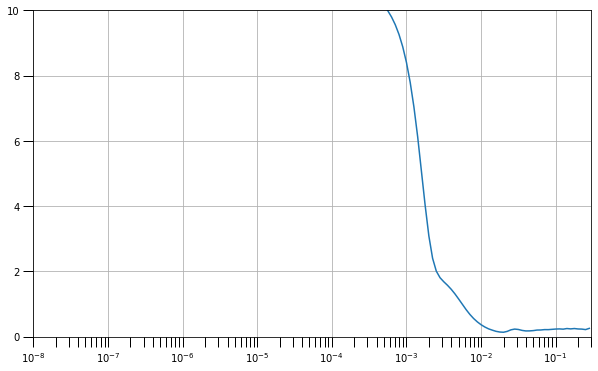

In [48]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(150) / 20))

# Plot
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 0.3, 0, 10])

In [49]:
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),loss=tf.keras.losses.MeanSquaredError(), metrics=["mae", "mse"])
model.fit([train.user_id, train.mountain_id], train.rating, epochs=100)

Epoch 1/100
81/81 [==============================] - 1s 2ms/step - loss: 0.2496 - mae: 0.3290 - mse: 0.2496
Epoch 2/100
81/81 [==============================] - 0s 4ms/step - loss: 0.1345 - mae: 0.2138 - mse: 0.1345
Epoch 3/100
81/81 [==============================] - 0s 4ms/step - loss: 0.0956 - mae: 0.1626 - mse: 0.0956
Epoch 4/100
81/81 [==============================] - 0s 4ms/step - loss: 0.0756 - mae: 0.1311 - mse: 0.0756
Epoch 5/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0641 - mae: 0.1112 - mse: 0.0641
Epoch 6/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0562 - mae: 0.0966 - mse: 0.0562
Epoch 7/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0506 - mae: 0.0856 - mse: 0.0506
Epoch 8/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0469 - mae: 0.0781 - mse: 0.0469
Epoch 9/100
81/81 [==============================] - 0s 3ms/step - loss: 0.0442 - mae: 0.0697 - mse: 0.0442
Epoch 10/100
81/81 [========

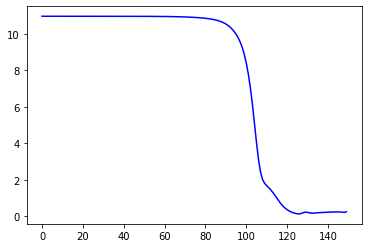

In [51]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

In [50]:
#Evaluate
model.evaluate([val.user_id, val.mountain_id], val.rating, return_dict=True)

21/21 [==============================] - 0s 1ms/step - loss: 3.1074 - mae: 1.4686 - mse: 3.1074


{'loss': 3.1074090003967285,
 'mae': 1.468593955039978,
 'mse': 3.1074090003967285}

In [57]:
#Test 
test_ratings = {}
test_mountain_ids = np.array(list(set(df.mountain_id)))
for mountain_id in test_mountain_ids:
  test_ratings[mountain_id] = model({
      "user_id": np.array([5]),
      "mountain_id": np.array([mountain_id])
  })

print("Ratings:")
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True)[:10]:
  print(f"{title}: {score}")

Ratings:
9: [[5.0178885]]
116: [[4.011862]]
219: [[3.8132002]]
187: [[3.714163]]
66: [[3.6332664]]
86: [[3.5711565]]
35: [[3.5607522]]
214: [[3.4580865]]
197: [[3.4170687]]
139: [[3.3958297]]


## **Saved and Convert Model**

In [58]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('recommendation_rankingbased.h5')

In [59]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('recommendation_rankingbased.h5')

# Show the model architecture
new_model.summary()

new_model.evaluate([val.user_id, val.mountain_id], val.rating, return_dict=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 mountain_id (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 32)        16032       ['user_id[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 32)        7456        ['mountain_id[0][0]']            
                                                                                              

{'loss': 3.1074090003967285,
 'mae': 1.468593955039978,
 'mse': 3.1074090003967285}